# Cluster, Label, PCA, then visualize
8JAN2020<br>
Richard Kuzma and Iain Cruickshank


### Imports

In [4]:
import pandas as pd, numpy as np, pickle, time, re

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA, KernelPCA

import seaborn as sns
from sklearn.metrics import classification_report, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from prettytable import PrettyTable
from prettytable import MSWORD_FRIENDLY, FRAME, ALL
from pprint import pprint

In [5]:
### load df with metadata

load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = '7800_tweets_known_domains_with_metadata.pkl'

with open(load_path + load_name, 'rb') as f:
    metadata_df = pickle.load(f)

    pd.set_option('display.max_columns', None)
metadata_df.head(3)


,created_at,id_str,entities,user,retweet_count,favorite_count,retweeted_status,Hash words,link,urls,first_url,url_total_retweets,url_total_favorites,article_text,article_text_preprocessed,domain,news,science,govt,dubious,not_any,group,month,week_num,no_www,fake_news,conspiracy,lean_left,lean_center,lean_right,lean_not_known,bias
0,2020-02-29 23:17:56+00:00,1.233894e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 1172275165524385798, 'id_str': '1172275...",0.0,0.0,NaN,No hashtags,https://twitter.com/user/status/12338942013953...,[https://nypost.com/2020/02/28/israeli-scienti...,https://nypost.com/2020/02/28/israeli-scientis...,1414.0,111.0,Thanks for contacting us. We've received your...,yaron steinbuch february updated february amid...,nypost.com,0,0,0,1,0,0,2020-02,9,nypost.com,0,0,0,0,1,0,5
1,2020-02-29 23:39:43+00:00,1.233900e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 465592070, 'id_str': '465592070', 'name...",0.0,0.0,NaN,No hashtags,https://twitter.com/user/status/12338996799240...,[https://nypost.com/2020/02/28/israeli-scienti...,https://nypost.com/2020/02/28/israeli-scientis...,310.0,1055.0,"\nNews\n By Yaron Steinbuch \n\tFebruary 28, ...",yaron steinbuch february amid fears looming sc...,nypost.com,0,0,0,1,0,0,2020-02,9,nypost.com,0,0,0,0,1,0,5
2,2020-02-29 23:40:00+00:00,1.233900e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 23081056, 'id_str': '23081056', 'name':...",328.0,0.0,{'created_at': 'Thu Feb 27 23:27:42 +0000 2020...,No hashtags,https://twitter.com/user/status/12338997538151...,[https://time.com/5790545/first-covid-19-vacci...,https://time.com/5790545/first-covid-19-vaccine/,73061.0,2115.0,"Moderna Therapeutics, a biotech company based...",moderna therapeutics biotech company based cam...,time.com,1,0,0,0,0,2,2020-02,9,time.com,0,0,1,0,0,0,3


<br><br><br>
### Make TFIDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=10, max_df=.8)
X = vectorizer.fit_transform(metadata_df['article_text_preprocessed'])
print('{} articles. Vocabulary: {} words'.format(X.shape[0], X.shape[1]))

### save the vectorizer
src_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
tfidf_save_name = 'tfidf_vectorizer_after_fit_transform.pkl'
with open(src_path + tfidf_save_name, 'wb') as f:
    pickle.dump(vectorizer, f)


# keep ID labels with tfidf features
tfidf_feat = pd.DataFrame(data=X.toarray())
id_strings = pd.DataFrame(data=metadata_df['id_str'], columns = ['id_str'])
id_strings.reset_index(inplace=True, drop=True)
tfidf_with_id_str = pd.concat([id_strings, tfidf_feat], axis=1, ignore_index=True)
tfidf_with_id_str.rename(columns={0: "id_str"}, inplace=True)
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
tfidf_save_name = 'tfidf_7800_articles_df.pkl'

with open(save_path + tfidf_save_name, 'wb') as f:
    pickle.dump(tfidf_with_id_str, f)


7824 articles. Vocabulary: 20212 words


<br><br>
### make PCA

In [7]:
from sklearn.decomposition import PCA
trans = PCA(n_components=2)
pca_feat = trans.fit_transform(tfidf_feat)

# pca_features_df = pd.DataFrame(data = pca_feat, columns = ['principal component 1', 'principal component 2'])

save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
save_name = 'pca_2d_feat_ndarray.pkl'

with open(save_path + save_name, 'wb') as f:
    pickle.dump(pca_feat, f)
    
pca_feat_df = pd.DataFrame(data=pca_feat)
id_strings = pd.DataFrame(data=metadata_df['id_str'], columns = ['id_str'])
id_strings.reset_index(inplace=True, drop=True)
pca_with_id_str = pd.concat([id_strings, pca_feat_df], axis=1, ignore_index=True)
pca_with_id_str.rename(columns={0: "id_str"}, inplace=True)

save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
save_name = 'pca_2d_7800_articles_df.pkl'

with open(save_path + save_name, 'wb') as f:
    pickle.dump(pca_with_id_str, f)


<br><br><br>
## Load PCA and TFIDF DataFrames

In [8]:
### load tfidf df
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = 'tfidf_7800_articles_df.pkl'

with open(load_path + load_name, 'rb') as f:
    tfidf_df = pickle.load(f)
tfidf_df.head(3)


### load pca df
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = 'pca_2d_7800_articles_df.pkl'

with open(load_path + load_name, 'rb') as f:
    pca_df = pickle.load(f)


pca_feat = pca_df.iloc[:, 1:]
pca_df.head()

### same number of articles for each
assert(pca_df.shape[0] == tfidf_df.shape[0] == metadata_df.shape[0])

<br><br><br>
## KMeans Clustering, apply labels

In [9]:
tfidf_feat = tfidf_df.iloc[:, 1:]

print('KMeans of TFIDF Features')
print('7800 articles, all domains, 20k vocab...\n')

preds_dict = {}
silhouettes_dict = {}

n_clusters = range(2,12)
for n_cluster in n_clusters:    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(tfidf_feat)
    preds = kmeans.predict(tfidf_feat)
    silhouette = silhouette_score(tfidf_feat, preds)
    
    preds_dict['k_means_' + str(n_cluster)] = preds
    silhouettes_dict['k_means_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster,silhouette))

### save
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'

preds_dict_save_name = 'kmeans_preds_dict.pkl'
silhouettes_dict_save_name = 'kmeans_silhouettes_dict.pkl'
# KMeans
with open(save_path + preds_dict_save_name, 'wb') as f:
    pickle.dump(preds_dict, f)
    
with open(save_path + silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(silhouettes_dict, f)


KMeans of TFIDF Features
7800 articles, all domains, 20k vocab...

Silhouette score for 2 clusters: 0.001802683480788329
Silhouette score for 3 clusters: 0.008246898675141497
Silhouette score for 4 clusters: 0.015503929405926589
Silhouette score for 5 clusters: 0.0184961167933309
Silhouette score for 6 clusters: 0.02825342621584356
Silhouette score for 7 clusters: 0.027234622588579793
Silhouette score for 8 clusters: 0.030772015858431492
Silhouette score for 9 clusters: 0.033568075815005635
Silhouette score for 10 clusters: 0.03474360391951401
Silhouette score for 11 clusters: 0.03778120025675651


<br><br><br>
## KMedoids

In [17]:
! pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

print('KMedoids of TFIDF Features with Cosine Distance')
print('7800 articles, all domains, 20k vocab\n')

medoids_preds_dict = {}
medoids_silhouettes_dict = {}

n_clusters = range(2,12)
for n_cluster in n_clusters:
    kmedoids = KMedoids(n_clusters=n_cluster, metric='cosine', 
                    init='heuristic', max_iter=300, random_state=42).fit(tfidf_feat)
    preds = kmedoids.labels_
    silhouette = silhouette_score(tfidf_feat, preds)
    
    medoids_preds_dict['k_medoids_' + str(n_cluster)] = preds
    medoids_silhouettes_dict['k_medoids_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster, silhouette))

### save
medoids_preds_dict_save_name = 'kmedoids_preds_dict.pkl'
medoids_silhouettes_dict_save_name = 'kmedoids_silhouettes_dict.pkl'

with open(save_path + medoids_preds_dict_save_name, 'wb') as f:
    pickle.dump(medoids_preds_dict, f)
    
with open(save_path + medoids_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(medoids_silhouettes_dict, f)


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.
KMedoids of TFIDF Features with Cosine Distance
7800 articles, all domains, 20k vocab

Silhouette score for 2 clusters: 0.005792211662212355
Silhouette score for 3 clusters: 0.007944229062763828
Silhouette score for 4 clusters: 0.0050895716006248695
Silhouette score for 5 clusters: 0.008127096959374623
Silhouette score for 6 clusters: 0.008894947356078542
Silhouette score for 7 clusters: 0.011529839299955732
Silhouette score for 8 clusters: 0.016711356610564578
Silhouette score for 9 clusters: 0.01748036885253735
Silhouette score for 10 clusters: 0.018173437290532786
Silhouette score for 11 clusters: 0.0183707486854288


<b><br><br>
### KMeans on PCA Features

In [18]:
### PCA features
print('KMeans of PCA Features')
print('7800 articles, all domains, 20k vocab...\n')

pca_kmeans_preds_dict = {}
pca_kmeans_silhouettes_dict = {}

n_clusters = range(2,12)
for n_cluster in n_clusters:    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(pca_feat)
    preds = kmeans.predict(pca_feat)
    silhouette = silhouette_score(pca_feat, preds)
    
    pca_kmeans_preds_dict['pca_k_means_' + str(n_cluster)] = preds
    pca_kmeans_silhouettes_dict['pca_k_means_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster,silhouette))

### save
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
pca_kmeans_preds_dict_save_name = 'pca_kmeans_preds_dict.pkl'
pca_kmeans_silhouettes_dict_save_name = 'pca_kmeans_silhouettes_dict.pkl'

with open(save_path + pca_kmeans_preds_dict_save_name, 'wb') as f:
    pickle.dump(pca_kmeans_preds_dict, f)
    
with open(save_path + pca_kmeans_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(pca_kmeans_silhouettes_dict, f)

KMeans of PCA Features
7800 articles, all domains, 20k vocab...

Silhouette score for 2 clusters: 0.81939172979715
Silhouette score for 3 clusters: 0.8603592311095735
Silhouette score for 4 clusters: 0.46790427623229003
Silhouette score for 5 clusters: 0.37541052485121457
Silhouette score for 6 clusters: 0.4271130116077903
Silhouette score for 7 clusters: 0.42092660253677966
Silhouette score for 8 clusters: 0.3771547578673032
Silhouette score for 9 clusters: 0.39087697056570386
Silhouette score for 10 clusters: 0.37539446786545466
Silhouette score for 11 clusters: 0.3850268392684832


<br><br><br>
# Open preds and silhouettes dictionaries
<br><br><br>


In [ ]:
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'

preds_dict_save_name = 'kmeans_preds_dict.pkl'
silhouettes_dict_save_name = 'kmeans_silhouettes_dict.pkl'
# medoids_preds_dict_save_name = 'kmedoids_preds_dict.pkl'
# medoids_silhouettes_dict_save_name = 'kmedoids_silhouettes_dict.pkl'
pca_kmeans_preds_dict_save_name = 'pca_kmeans_preds_dict.pkl'
pca_kmeans_silhouettes_dict_save_name = 'pca_kmeans_silhouettes_dict.pkl'

# KMeans
with open(save_path + preds_dict_save_name, 'rb') as f:
    preds_dict = pickle.load(f)
    
with open(save_path + silhouettes_dict_save_name, 'rb') as f:
    silhouettes_dict = pickle.load(f)
    
# # KMedoids
# with open(save_path + medoids_preds_dict_save_name, 'rb') as f:
#     medoids_preds_dict = pickle.load(f)
    
# with open(save_path + medoids_silhouettes_dict_save_name, 'rb') as f:
#     medoids_silhouettes_dict = pickle.load(f)
    
# PCA KMeans
with open(save_path + pca_kmeans_preds_dict_save_name, 'rb') as f:
    pca_kmeans_preds_dict = pickle.load(f)
    
with open(save_path + pca_kmeans_silhouettes_dict_save_name, 'rb') as f:
    pca_kmeans_silhouettes_dict = pickle.load(f)

<br><br><br>
### Plot Silhouette Scores

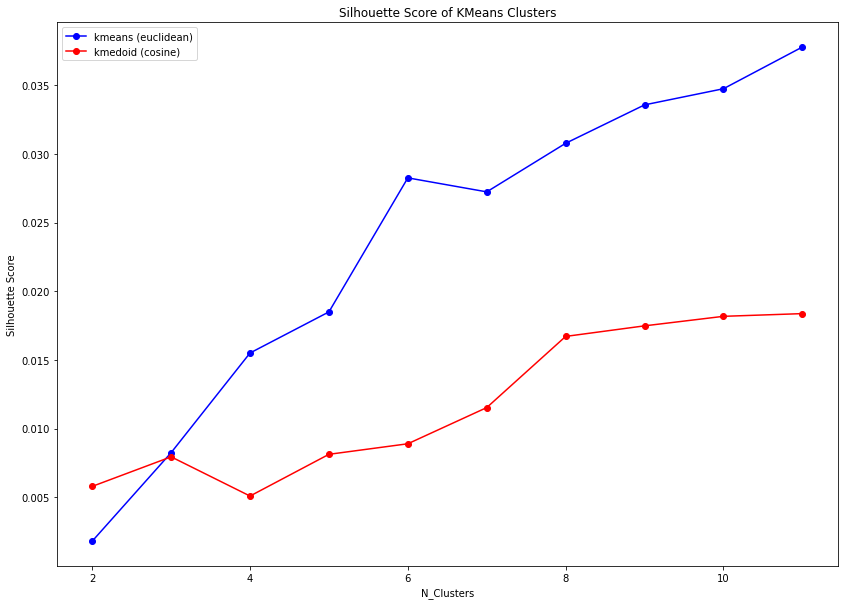

In [19]:
plt.figure(figsize=(14,10))
plt.plot(n_clusters, silhouettes_dict.values(), 'bo-', label='kmeans (euclidean)')
plt.plot(n_clusters, medoids_silhouettes_dict.values(), 'ro-', label='kmedoid (cosine)')

plt.title('Silhouette Score of KMeans Clusters')
plt.ylabel('Silhouette Score')
plt.xlabel('N_Clusters')
plt.legend()
plt.show()

Elbows at n_clusters = 6 (KMeans) and n_clusters = 8 (KMedoids)
<br><br><br><br><br><br><br><br><br>

### Plot PCA scatter plot with clustering labels for colors

In [45]:
color_dict_labels = {'0': 'xkcd:blue', '1': 'xkcd:light green', '2': 'xkcd:orange',
                     '3': 'xkcd:red', '4': 'xkcd:pink', '5': 'xkcd:yellow',
                     '6': 'xkcd:dark green', '7': 'xkcd:cyan', '8': 'xkcd:navy blue',
                     '9': 'xkcd:maroon', '10': 'xkcd:magenta', '11': 'xkcd:violet',
                     '12': 'xkcd:green', '13': 'xkcd:olive',
                    }

def plot_pca_clustering(num_clusters=6, cluster_type='kmeans'):
    
    print('Num clusters: {}'.format(num_clusters))
    print('cluster type: ' + cluster_type)
    
    
    plt.figure(figsize=(14,10))
    if cluster_type == 'kmeans':
        key = 'k_means_' + str(num_clusters)
        plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in preds_dict[key]],
                        alpha=.05,
                        s = 100
                       )
    elif cluster_type == 'kmedoids':
        key = 'k_medoids_' + str(num_clusters)
        plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in medoids_preds_dict[key]],
                        alpha=.05,
                        s = 100
                       )
    plt.title('2-Dim PCA Scatter\n'+cluster_type+': n_clusters = {}'.format(num_clusters))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

Num clusters: 6
cluster type: kmeans


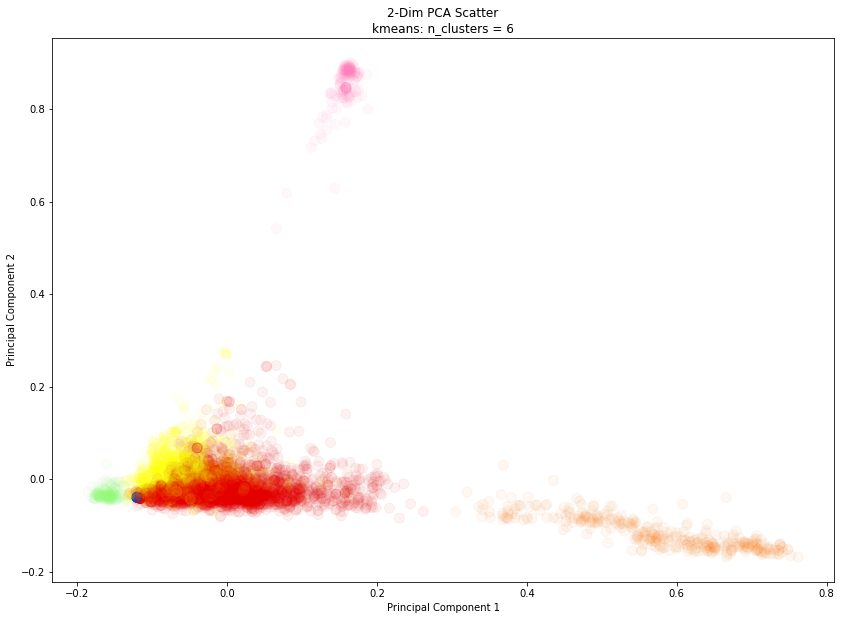


colors
group 0 color: xkcd:blue
group 1 color: xkcd:light green
group 2 color: xkcd:orange
group 3 color: xkcd:red
group 4 color: xkcd:pink
group 5 color: xkcd:yellow

Articles per topic group
[[   0   49]
 [   1  139]
 [   2  337]
 [   3 5142]
 [   4  157]
 [   5 2000]]


In [120]:
plot_pca_clustering(6, 'kmeans')
print('\ncolors')
for i in range(6):
    print(f'group {i} color: {color_dict_labels[str(i)]}')

print('\nArticles per topic group')
unique, counts = np.unique(preds_dict['k_means_6'], return_counts=True)
print(np.asarray((unique, counts)).T)


N_Clusters = 5 shows three outlying groups (light green, pink, orange) but 7000 of the 7800 articles are topic 3 (red) or topic 5 (yellow). 
<br><br><br><br><br>

Num clusters: 8
cluster type: kmedoids


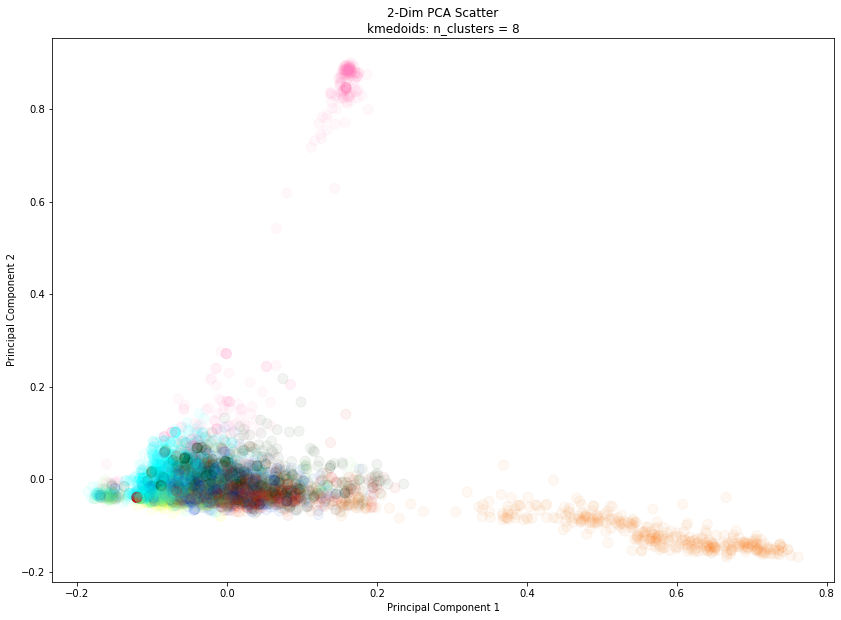


colors
group 0 color: xkcd:blue
group 1 color: xkcd:light green
group 2 color: xkcd:orange
group 3 color: xkcd:red
group 4 color: xkcd:pink
group 5 color: xkcd:yellow
group 6 color: xkcd:dark green
group 7 color: xkcd:cyan
group 8 color: xkcd:navy blue

Articles per topic group
[[   0 1667]
 [   1 1148]
 [   2  590]
 [   3  732]
 [   4  337]
 [   5  309]
 [   6 1422]
 [   7 1619]]


In [119]:
plot_pca_clustering(8, 'kmedoids')
print('\ncolors')
for i in range(9):
    print(f'group {i} color: {color_dict_labels[str(i)]}')
    
print('\nArticles per topic group')
unique, counts = np.unique(medoids_preds_dict['k_medoids_8'], return_counts=True)
print(np.asarray((unique, counts)).T)


KMedoids n_clusters = 8
- Harder to see in 2-d... will need to see how top words shape out
- More balance among classes. We may see better sub-narratives within the overarching coronavirus storyline
- Perhaps we can show only a few layers at a time to see how the main cluster breaks down

# Next Step

In [35]:
metadata_cols_to_keep = ['id_str', 'url_total_retweets', 'url_total_favorites', 'group', 'bias', 'month', 'week_num' ]
metadata_small = metadata_df.copy(deep=True)
metadata_small = metadata_small[metadata_cols_to_keep]
pca_ready = pd.merge(pca_df, metadata_small, on=["id_str"])
tfidf_ready = pd.merge(tfidf_df, metadata_small, on=["id_str"])

pca_ready['k_means_6'] = preds_dict['k_means_6']
tfidf_ready['k_means_6'] = preds_dict['k_means_6']

pca_ready['k_medoids_8'] = medoids_preds_dict['k_medoids_8']
tfidf_ready['k_medoids_8'] = medoids_preds_dict['k_medoids_8']

In [39]:
def top_words(col_name, label, input_df=tfidf_ready, n_words=25):
    df = input_df.copy()
    top_words_list = []
    num_tfidf_features = range(1, tfidf_df.shape[1])    
    temp_df = df[df[col_name] == label]
    means = []

    for feat in num_tfidf_features:
        means.append(temp_df[feat].mean())
    means = np.array(means)

    feature_array = np.array(vectorizer.get_feature_names())
    sorted_word_idxs = np.argsort(means).flatten()[::-1]
    top_words = list(feature_array[sorted_word_idxs][:n_words])
    return top_words

In [115]:
n_words = 250
topics = 6
method = 'k_means_'

print(f'Top {n_words} words in each of the {topics} topic groups')
for i in range(topics):
    print('\n' + '-'*80)
    print(f'\nTopic Group #{i}')
    print(top_words(method+str(topics), label=i, n_words=n_words))
    

Top 100 words in each of the 6 topic groups

--------------------------------------------------------------------------------

Topic Group #0
['sciencedirect', 'elsevier', 'licensors', 'tailor', 'provide', 'enhance', 'reference', 'shopping', 'continuing', 'attacks', 'security', 'center', 'policy', 'protect', 'using', 'information', 'number', 'fare', 'fanlight', 'fanned', 'farce', 'fanning', 'faqs', 'fantasy', 'faq', 'fao', 'fans', 'fang', 'fantastic', 'zydus', 'fancy', 'fanciful', 'falsely', 'falsified', 'fam', 'fame', 'famed', 'familial', 'familiar', 'familiarity', 'families', 'family', 'famine', 'famous', 'famously', 'fan', 'farge', 'fared', 'farmed', 'fargo', 'fated', 'fasting', 'fat', 'fatal', 'fatalities', 'fatality', 'fatally', 'fate', 'fates', 'faster', 'father', 'fatigue', 'fats', 'fatty', 'fauci', 'faulconbridge', 'fault', 'fastest', 'fastened', 'farhad', 'farrar', 'faring', 'farm', 'falsehood', 'farmer', 'farmers', 'farming', 'farms', 'farther', 'fast', 'farzan', 'fascinating

['people', 'new', 'cases', 'trump', 'china', 'flu', 'world', 'public', 'disease', 'government', 'information', 'outbreak', 'president', 'children', 'time', 'countries', 'states', 'like', 'vaccination', 'gates', 'country', 'patients', 'year', 'deaths', 'state', 'cdc', 'global', 'research', 'spread', 'wuhan', 'number', 'medical', 'influenza', 'need', 'risk', 'testing', 'going', 'care', 'study', 'lockdown', 'million', 'data', 'infected', 'infection', 'reported', 'national', 'home', 'united', 'work', 'social', 'week', 'day', 'including', 'symptoms', 'times', 'officials', 'according', 'years', 'fauci', 'know', 'told', 'make', 'death', 'infections', 'days', 'story', 'available', 'months', 'think', 'media', 'science', 'university', 'chinese', 'human', 'rights', 'percent', 'read', 'immunity', 'scientists', 'confirmed', 'privacy', 'test', 'say', 'response', 'travel', 'hospital', 'diseases', 'way', 'long', 'measles', 'control', 'used', 'tests', 'measures', 'drug', 'viruses', 'city', 'march', 'ho

In [118]:
k_means_table = PrettyTable()
k_means_table.field_names = ['Label', 'Color', 'Topic', 'N_Articles', 'Selected Top Words']
k_means_table.add_row(['0', 'Blue', 'Fa...', '49', 'farge, fared, farmed, fargo, fated, fasting,\n'])
k_means_table.add_row(['1', 'Light Green', 'Vaccine Dev', '139',  'Astrazenica, Moderna, Trials, Breakthrough, Potential, Testing, Mass, Vial\n'])
k_means_table.add_row(['2', 'Orange', 'Politics', '337', 'Biden, President, Trump, Brazil, Schumer, Republicans, Protesters, McConnell, Chechen, Protested\n'])
k_means_table.add_row(['3', 'Red', 'Response', '5142', 'New, Cases, Trump, China, Flu, World, Public, Disease, Government, Information, Outbreak, Wuhan, Gates\n'])
k_means_table.add_row(['4', 'Pink', 'Finance',  '157', 'Vanguard, Stock, Company, Market, Buy, Investors, Shares, Growth\n'])
k_means_table.add_row(['5', 'Yellow', 'Drug Trials', '2000', 'Trials, Trial, Doses, Clinical, Moderna, Oxford, Astrazenica, Antibodies, Testing, Research, Animals, Promising, Drugmaker\n'])

k_means_table._max_width = {'Label': 5, 'Selected Top Words': 40}

k_means_table.align = 'l'

print('KMeans / 6 Topics\n')
print(k_means_table)


KMeans / 6 Topics

+-------+-------------+-------------+------------+------------------------------------------+
| Label | Color       | Topic       | N_Articles | Selected Top Words                       |
+-------+-------------+-------------+------------+------------------------------------------+
| 0     | Blue        | Fa...       | 49         | farge, fared, farmed, fargo, fated,      |
|       |             |             |            | fasting,                                 |
|       |             |             |            |                                          |
| 1     | Light Green | Vaccine Dev | 139        | Astrazenica, Moderna, Trials,            |
|       |             |             |            | Breakthrough, Potential, Testing, Mass,  |
|       |             |             |            | Vial                                     |
|       |             |             |            |                                          |
| 2     | Orange      | Politics    | 337

In [48]:
n_words = 250
topics = 8
method = 'k_medoids_'

print(f'Top {n_words} words in each of the {topics} topic groups')
for i in range(topics):
    print('\n' + '-'*80)
    print(f'\nTopic Group #{i}')
    print(top_words(method+str(topics), label=i, n_words=n_words))
    

Top 100 words in each of the 8 topic groups

--------------------------------------------------------------------------------

Topic Group #0
['china', 'people', 'cases', 'outbreak', 'new', 'world', 'countries', 'disease', 'research', 'global', 'december', 'chinese', 'spread', 'infected', 'wuhan', 'scientists', 'public', 'states', 'researchers', 'united', 'patients', 'testing', 'reported', 'university', 'trials', 'time', 'officials', 'country', 'development', 'year', 'confirmed', 'study', 'organization', 'trump', 'infection', 'according', 'symptoms', 'data', 'clinical', 'national', 'government', 'million', 'human', 'number', 'beijing', 'work', 'science', 'develop', 'told', 'medical', 'state', 'including', 'epidemic', 'city', 'director', 'months', 'children', 'infections', 'president', 'test', 'deaths', 'information', 'south', 'developed', 'like', 'diseases', 'need', 'days', 'trial', 'control', 'cdc', 'times', 'travel', 'tested', 'tedros', 'transmission', 'response', 'risk', 'march', 'i

['cases', 'people', 'new', 'sciencedirect', 'deaths', 'number', 'elsevier', 'lockdown', 'government', 'country', 'testing', 'trump', 'million', 'public', 'death', 'minister', 'week', 'provide', 'infections', 'according', 'day', 'confirmed', 'state', 'valid', 'england', 'university', 'licensors', 'countries', 'data', 'reported', 'restrictions', 'states', 'world', 'tests', 'disease', 'tailor', 'home', 'social', 'time', 'cent', 'test', 'positive', 'told', 'nhs', 'patients', 'daily', 'rate', 'shopping', 'enter', 'fauci', 'year', 'risk', 'distancing', 'continuing', 'president', 'days', 'officials', 'tested', 'measures', 'going', 'information', 'enhance', 'today', 'reference', 'children', 'policy', 'masks', 'johnson', 'total', 'infection', 'care', 'june', 'december', 'tracing', 'oxford', 'attacks', 'spread', 'second', 'trials', 'protect', 'need', 'available', 'work', 'infected', 'weeks', 'face', 'wave', 'using', 'outbreak', 'like', 'center', 'say', 'reopening', 'end', 'months', 'hopkins', 's

['trials', 'trial', 'immune', 'moderna', 'phase', 'clinical', 'antibodies', 'human', 'doses', 'protein', 'company', 'cells', 'oxford', 'people', 'development', 'study', 'candidate', 'astrazeneca', 'mrna', 'researchers', 'university', 'response', 'safety', 'research', 'testing', 'volunteers', 'antibody', 'manufacturing', 'dose', 'developed', 'infection', 'disease', 'effective', 'scientists', 'new', 'potential', 'million', 'candidates', 'based', 'studies', 'data', 'spike', 'year', 'experimental', 'world', 'produce', 'results', 'humans', 'stage', 'develop', 'early', 'efficacy', 'drug', 'institute', 'work', 'immunity', 'participants', 'production', 'nih', 'proteins', 'safe', 'months', 'cell', 'start', 'rna', 'make', 'body', 'working', 'companies', 'monkeys', 'science', 'viral', 'speed', 'test', 'patients', 'responses', 'group', 'team', 'johnson', 'technology', 'healthy', 'like', 'global', 'need', 'available', 'sanofi', 'dna', 'different', 'using', 'china', 'challenge', 'animals', 'genetic'

In [124]:
k_medoids_table = PrettyTable()
k_medoids_table.field_names = ['Label', 'Color', 'Topic', 'N_Articles', 'Selected Top Words']
k_medoids_table.add_row(['0', 'Blue', 'Onset', '1667', 'China, Cases, Outbreak, New, World, Countries, Disease, Global, December, New, Italy, Outbreak, January, February\n'])
k_medoids_table.add_row(['1', 'Light Green','Conspiracy', '1148',  'Wuhan, Gates, Natural, Children, Bats, Conspiracy, Autism, Lab, Truth, Vitamin, Chinese, Theory, Polio, \n'])
k_medoids_table.add_row(['2', 'Orange', 'Politics', '590', 'Biden, President, Trump, Brazil, Schumer, Republicans, Anzorov, McConnell, Chechen, Protested, Forgiving\n'])
k_medoids_table.add_row(['3', 'Red', 'Response', '732', 'Deaths, Number, Lockdown, Public, Infections, Day, Fauci, June, Distancing, Reopening, Quarantine, Surge, Stay, Boris, Open, Rise, Surge, Evidence, Community\n'])
k_medoids_table.add_row(['4', 'Pink', 'Finance',  '337', 'Vanguard, Stock, Market, Buy, Investors, Shares, Quarter, Fund, Buys, Index, Bullish, Bridgewater\n'])
k_medoids_table.add_row(['5', 'Yellow', 'Anti-Vax.', '309', 'Pandemrix, Narcolepsy, Hepatitis, HPV, Influenza, Autism, Surveillance, Pregnant, Swine, Guillain, Meningococcal, Unvaccinated\n'])
k_medoids_table.add_row(['6', 'Dark Green', 'Lockdowns', '1422', 'Trump, Government, World, President, Lockdown, Mercola, Djokovic, Children, British, States, Time, Work, Restrictions, Mask, Schools, Privacy, Risk, Rights, Workers, Capacity\n'])
k_medoids_table.add_row(['7', 'Cyan', 'Vaccine Trials', '1619', 'Trials, Immune, Moderna, Doses, Oxford, Astrazenica, MRNA, Production, Protein, Volunteers, Stage, Efficacy, RNA, Science, Biotech\n'])


k_medoids_table._max_width = {'Label': 5, 'Selected Top Words': 40}

k_medoids_table.align = 'l'
# k_medoids_table.hrules = FRAME

print('K Medoids / 8 Topics\n')
print(k_medoids_table)

K Medoids / 8 Topics

+-------+-------------+----------------+------------+------------------------------------------+
| Label | Color       | Topic          | N_Articles | Selected Top Words                       |
+-------+-------------+----------------+------------+------------------------------------------+
| 0     | Blue        | Onset          | 1667       | China, Cases, Outbreak, New, World,      |
|       |             |                |            | Countries, Disease, Global, December,    |
|       |             |                |            | New, Italy, Outbreak, January, February  |
|       |             |                |            |                                          |
| 1     | Light Green | Conspiracy     | 1148       | Wuhan, Gates, Natural, Children, Bats,   |
|       |             |                |            | Conspiracy, Autism, Lab, Truth, Vitamin, |
|       |             |                |            | Chinese, Theory, Polio,                  |
|       

In [125]:
pca_ready.head()

,id_str,1,2,url_total_retweets,url_total_favorites,group,bias,month,week_num,k_means_6,k_medoids_8
0,1.233894e+18,-0.081050,-0.004754,1414.0,111.0,0,5,2020-02,9,5,7
1,1.233900e+18,-0.086199,-0.000857,310.0,1055.0,0,5,2020-02,9,5,7
2,1.233900e+18,-0.059322,-0.018571,73061.0,2115.0,2,3,2020-02,9,5,7
3,1.233900e+18,0.063228,-0.002313,0.0,0.0,2,2,2020-02,9,3,0
4,1.233904e+18,-0.014116,-0.023931,48.0,71.0,2,3,2020-02,9,3,0


In [139]:
def plot_clusters(title: str, unit = "-1", col = 'k_medoids_8', color_by = 'k_medoids_8', input_df=pca_ready, label1=-1, label2=-1, label3 = -1, label4=-1, alpha=0.05):
    df = input_df.copy()
    print('col: ' + col )
    print('time unit: ' + unit)
    print('color_by: ' + color_by)
    
    ### color by
    if color_by == 'k_medoids_8':
        color_dict = color_dict_labels
        print('Coloring by Topic Labels')
    elif color_by == 'group':
        color_dict = color_dict_domains
        print('Coloring by Domain Group')
    elif cluster_type == 'bias':
        color_dict = color_dict_bias
        print('Coloring by Political Bias')

        
    ### select up to 4 labels (or all labels)
    if (label1 != -1) and (label2 != -1) and (label3 != -1) and (label4 != -1):
        df = df[(df[col] == label1) | (df[col] == label2) | (df[col] == label3) | (df[col] == label4)]    
    elif (label1 != -1) and (label2 != -1) and (label3 != -1):
        df = df[(df[col] == label1) | (df[col] == label2) | (df[col] == label3)]
    elif (label1 != -1) and (label2 != -1):
        df = df[(df[col] == label1) | (df[col] == label2)]
    elif label1 != -1:
        df = df[df[col] == label1]
        
    
    ### time
    if unit != '-1':
        if unit == 'month':
            time = pca_ready['month'].value_counts().sort_index().index
        elif unit == 'week_num':
            time = pca_ready['week_num'].value_counts().sort_index().index


        for t in time:
            plt.figure()
            plt.figure(figsize=(10,8))
            plt.xlim(-.3, .8)
            plt.ylim(-.3, .95)

            df_time = df[df[unit] == t]
    #         print(df_month.shape)

            plt.title(title + '\n' + unit + ': ' + str(t))
            plt.scatter(df_time[1], df_time[2], 
                    c = [color_dict[str(i)] for i in df_time[color_by]],
                    alpha=alpha,
                    s = 100
                   )
    elif unit == '-1':
        plt.figure(figsize=(14,10))
        plt.title(title)
        plt.scatter(df[1], df[2], 
                    c = [color_dict[str(i)] for i in df[color_by]],
                    alpha=alpha,
                    s = 100
                   )
  
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.xlim(-.3,.8)
    plt.ylim(-.3,.95)
    plt.show()

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


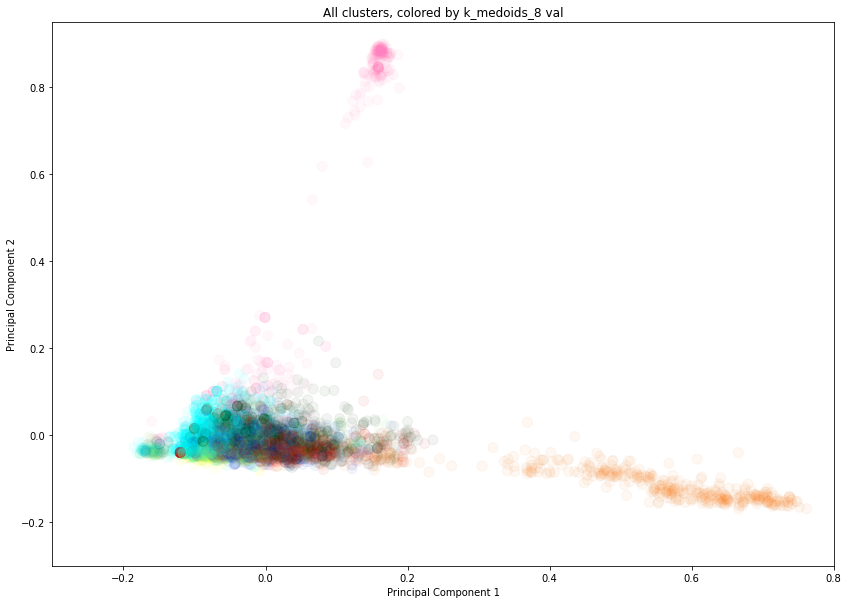

In [140]:
plot_clusters(title='All clusters, colored by k_medoids_8 val')

Each Topic Group
col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


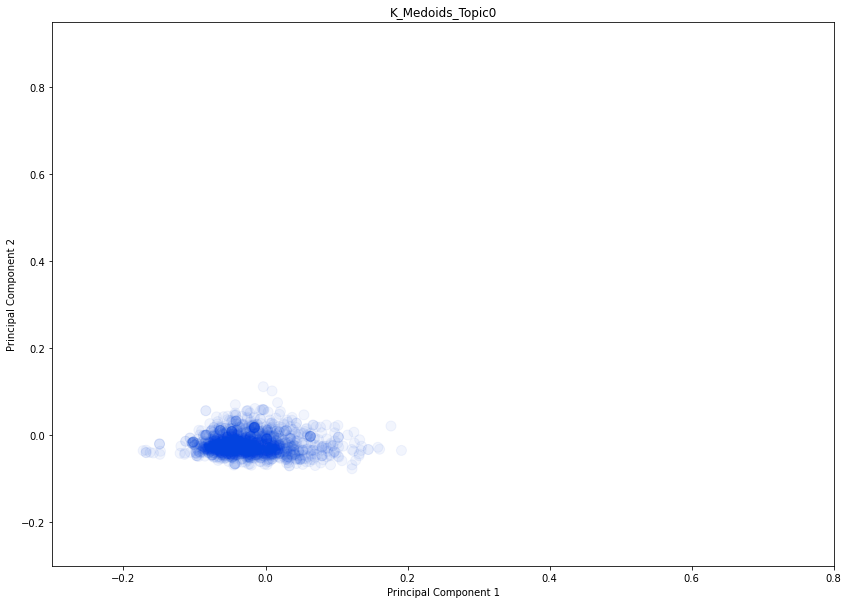

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


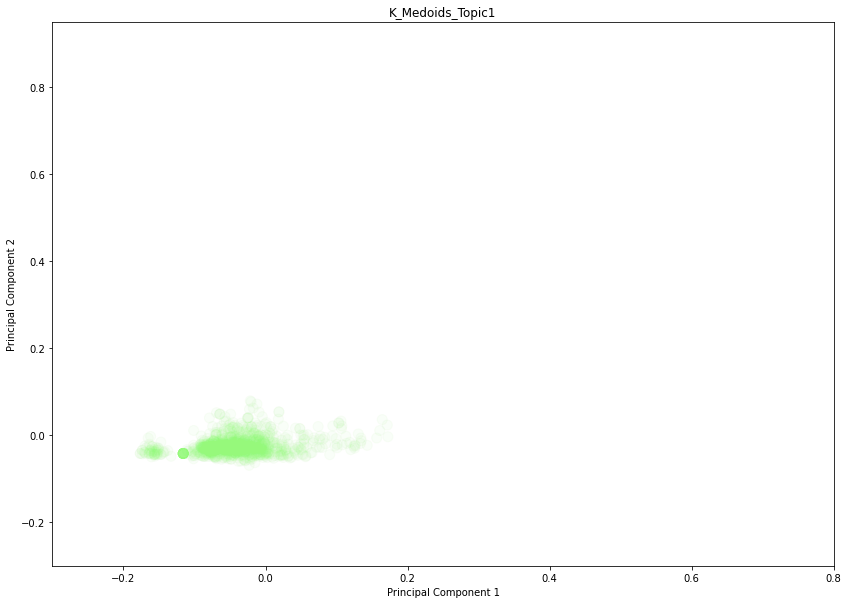

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


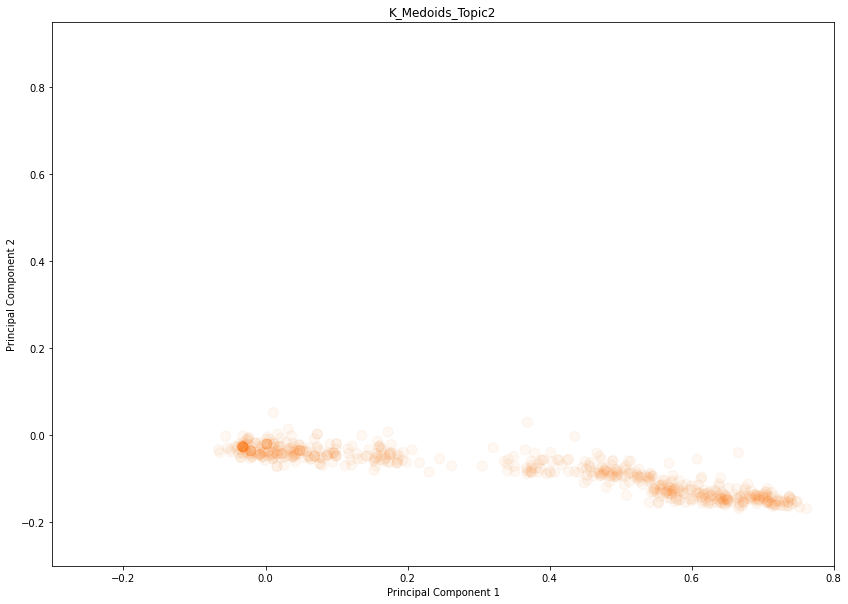

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


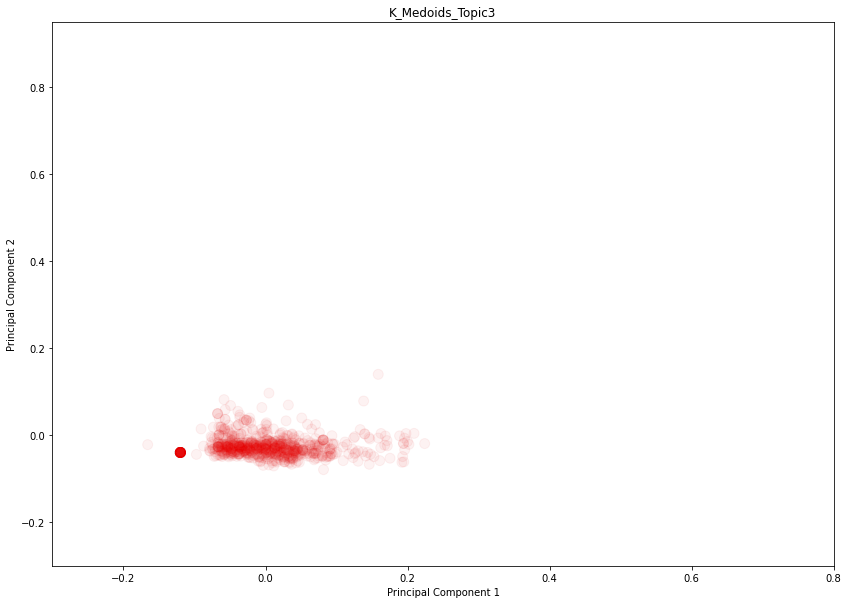

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


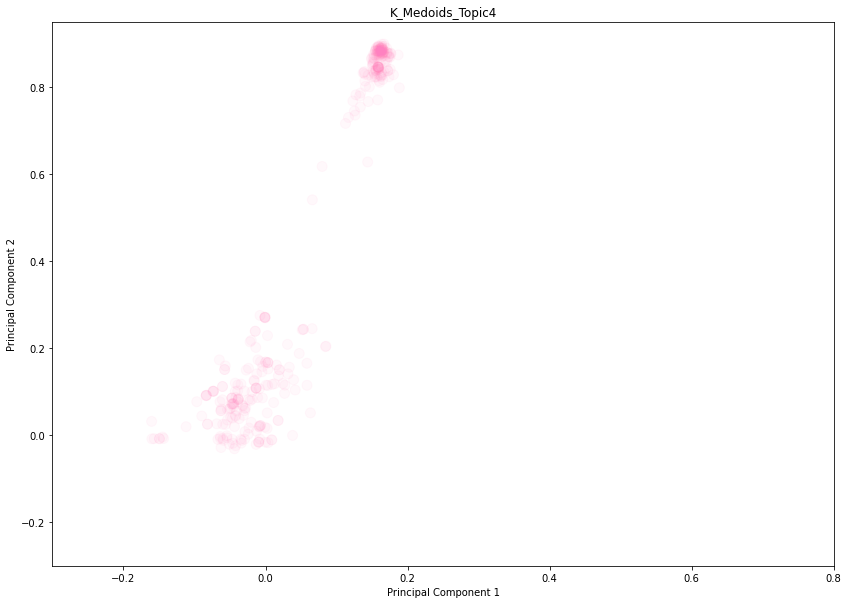

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


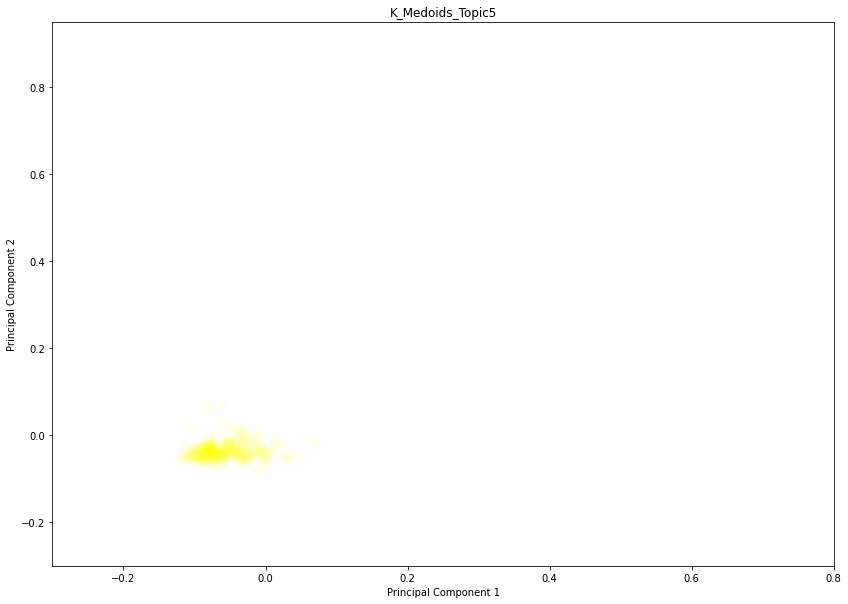

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


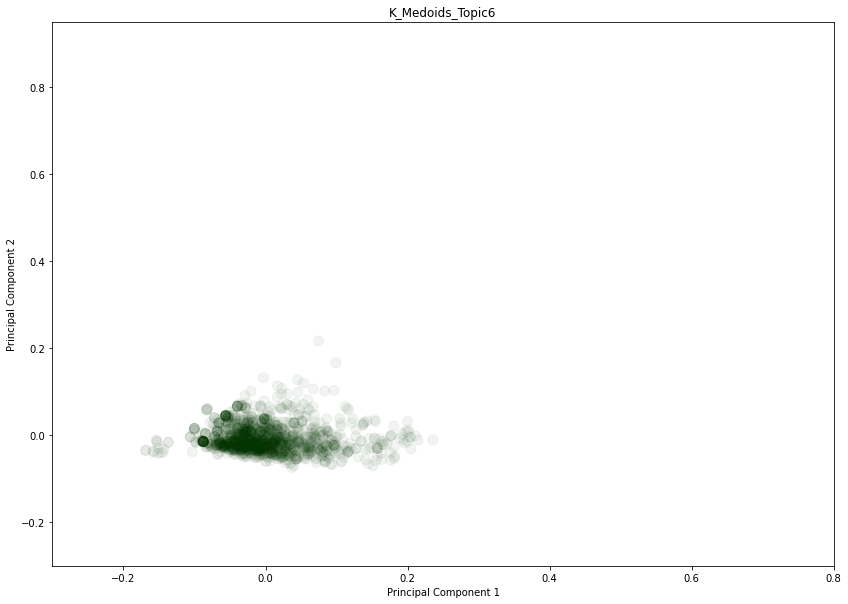

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


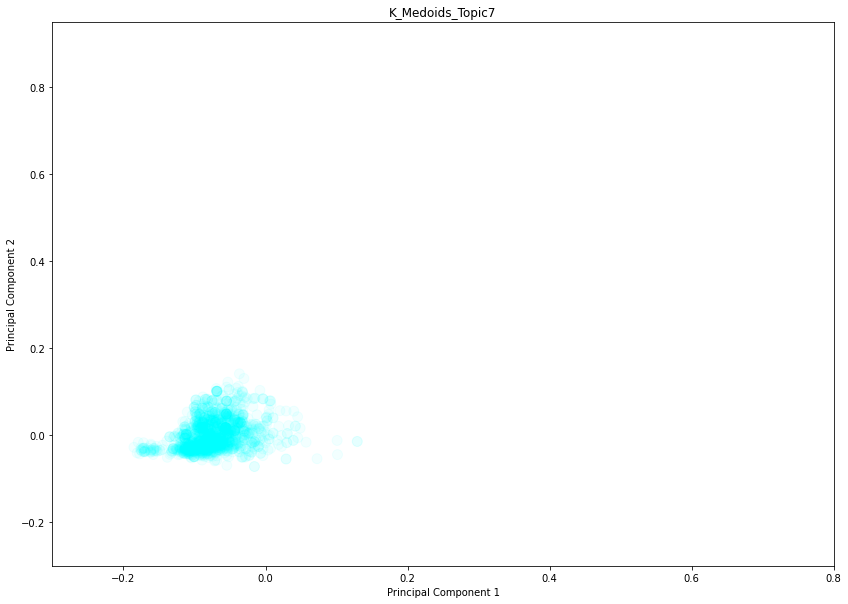

In [154]:
### Many topics overlap in 2-d plot
print('Each Topic Group')
for i in range(8):
    plot_clusters(title='K_Medoids_Topic' + str(i), label1=i)

In [160]:
# for topic in range(8):
#     print(f'Topic {topic} over time')
#     plot_clusters(title='K_Medoids_Topic' + str(topic), label1=topic, unit="week_num")

# Heatmap

In [245]:
temp = pca_ready.copy(deep=True)
months = pca_ready['month'].value_counts().sort_index().index
weeks = pca_ready['week_num'].value_counts().sort_index().index

In [283]:
temp_df = pca_ready.copy(deep=True)
def article_counts_matrix(time_name:str, normalize_on:str, df = temp_df, col='k_medoids_8'):
    if time_name == 'month':
        times = months
    elif time_name == 'week_num':
        times = weeks


    all_topics = []
    for topic in range(8):
        this_topic = []
    #     print(f'\ntopic: {topic}')
        topic_sum = pca_ready[df[col] == topic].shape[0]
    #     print(f'topic sum: {topic_sum}')
        for time_unit in times:
            this_topic.append(df[(df[col] == topic) & (df[time_name] == time_unit)].shape[0])
    #     print(this_topic)
        all_topics.append(this_topic)
    #     print(f'all topics: {all_topics}')

    raw_counts = np.vstack(np.asarray(topic_list) for topic_list in all_topics)
    normalized = raw_counts.astype('float32')
    
    if normalize_on == 'topic':
#         for i in range(normalized.shape[0]):
#             temp = normalized[i].copy()
#             row_sum = float(temp.sum())
#             temp = temp/row_sum
#             normalized[i] = temp
        return normalized/normalized.sum(axis=1,keepdims=1)
    elif normalize_on == 'time':
        return normalized/normalized.sum(axis=0,keepdims=1)



/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



Topic 5 (anti-vax) decreases over time. Topics 0, 1 start strong, dip, then get strong again. 2, 3, 4, start slow get much stronger


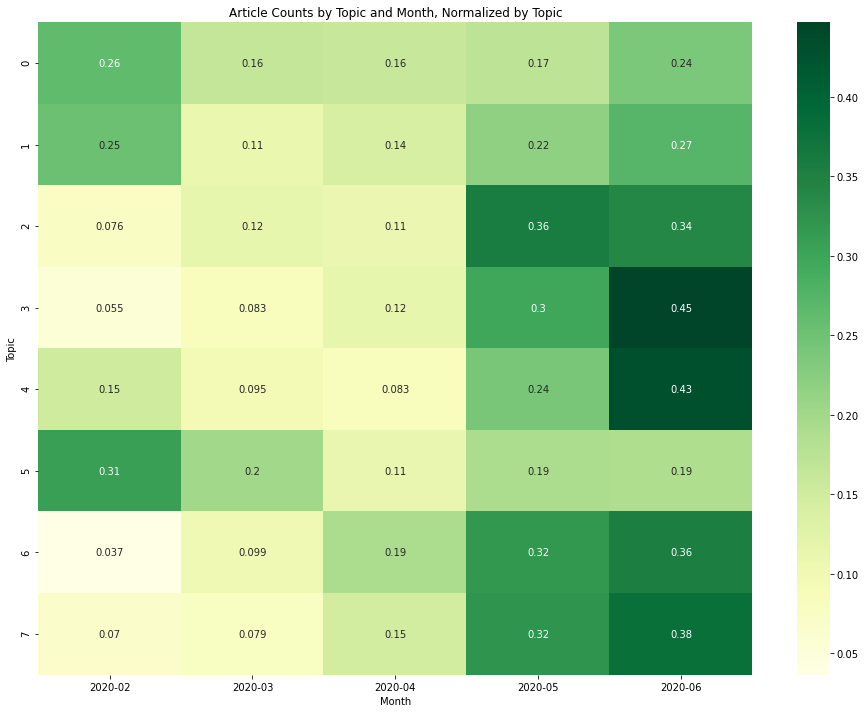

In [284]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_month_topic_normalized = article_counts_matrix(time_name='month', normalize_on='topic')
sns.heatmap(counts_by_month_topic_normalized, annot=True, cmap='YlGn', xticklabels=months, ax=ax)
ax.set_title('Article Counts by Topic and Month, Normalized by Topic')
ax.set_xlabel('Month')
ax.set_ylabel('Topic')

print('\nTopic 5 (anti-vax) decreases over time. Topics 0, 1 start strong, dip, then get strong again. 2, 3, 4, start slow get much stronger')



/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



Topic 0 and 1 dominate Feb-Mar, Topics 6 and 7 stronger April-June


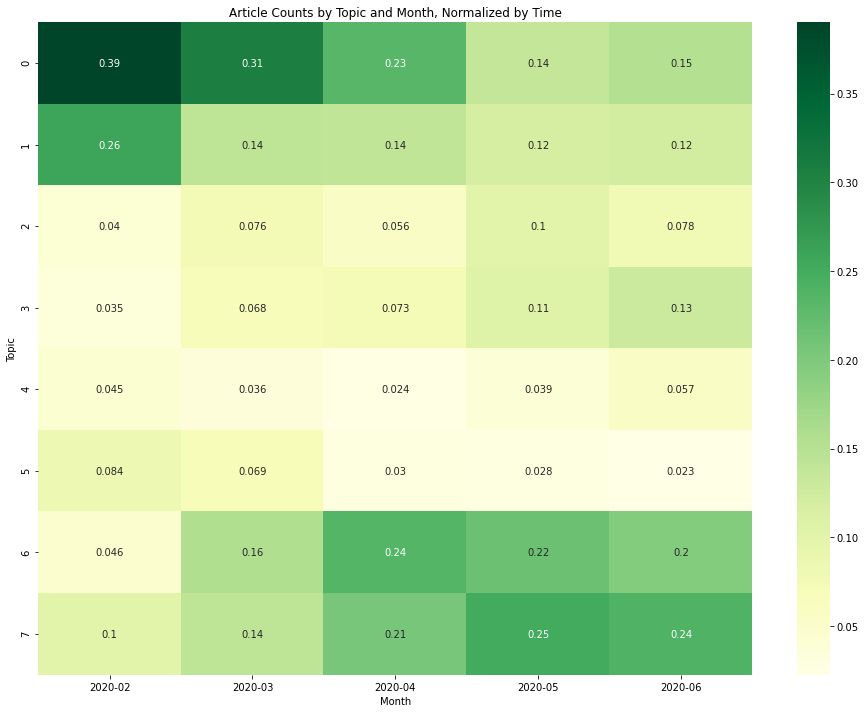

In [272]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_month_time_normalized = article_counts_matrix(time_name='month', normalize_on='time')
sns.heatmap(counts_by_month_time_normalized, annot=True, cmap='YlGn', xticklabels=months, ax=ax)
ax.set_title('Article Counts by Topic and Month, Normalized by Time')
ax.set_xlabel('Month')
ax.set_ylabel('Topic')

print('\nTopic 0 and 1 dominate Feb-Mar, Topics 6 and 7 stronger April-June')


In [261]:
b = counts_by_month_topic_normalized/counts_by_month_topic_normalized.sum(axis=1,keepdims=1)
print(b)

[[0.26394722 0.164967   0.16136773 0.17216557 0.2375525 ]
 [0.2543554  0.11149826 0.14285715 0.21777004 0.27351916]
 [0.07627118 0.11525424 0.11016949 0.35762712 0.34067798]
 [0.05464481 0.08333334 0.11612022 0.29918033 0.44672132]
 [0.15133531 0.09495549 0.08308605 0.24035609 0.43026707]
 [0.30744338 0.20064725 0.11326861 0.19093852 0.18770227]
 [0.03656821 0.09915612 0.19127989 0.31786215 0.35513362]
 [0.06979617 0.07906115 0.14762199 0.3230389  0.38048178]]


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

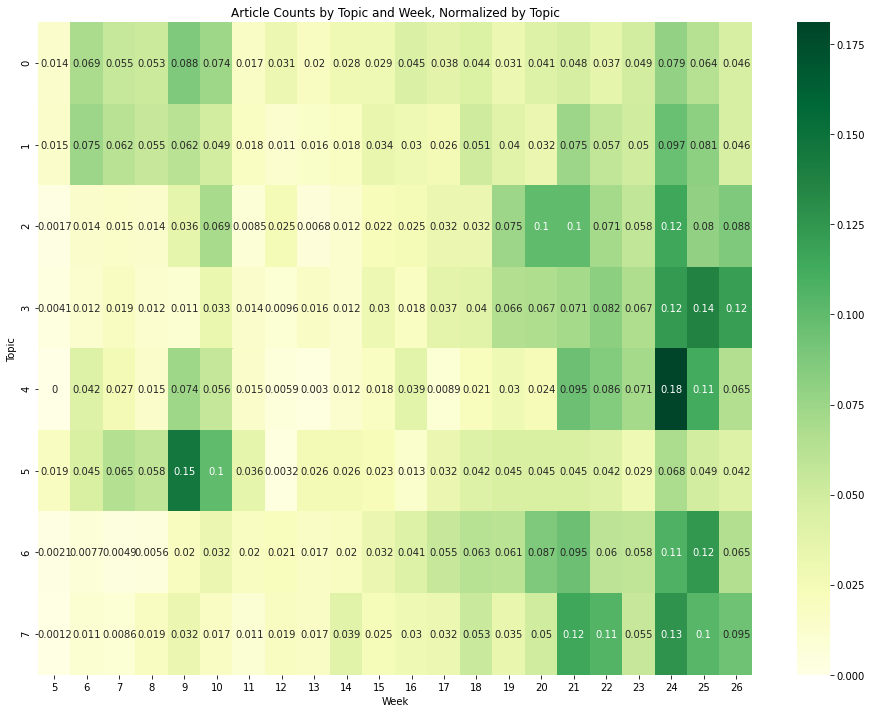

In [259]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_topic_normalized = article_counts_matrix(time_name='week_num', normalize_on='topic')
sns.heatmap(counts_by_week_topic_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('Article Counts by Topic and Week, Normalized by Topic')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')



/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

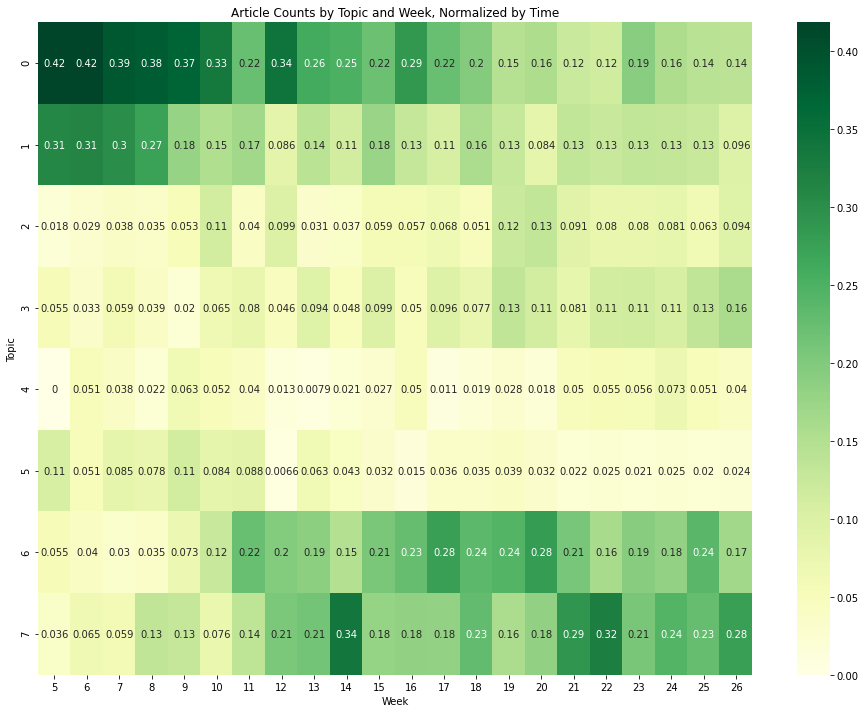

In [274]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(time_name='week_num', normalize_on='time')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('Article Counts by Topic and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

In [287]:
# maybe do same thing with bias or domain?

# ================================================
# ================================================
# ================================================

<br><br><br>
## Adjusted Rand Index / Adjusted Mutual Information Score

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
print('Domain Group vs Bias')
print('ARI: {}'.format(adjusted_rand_score(metadata_df['group'].tolist(), metadata_df['bias'].tolist())))
print('AMI: {}'.format(adjusted_mutual_info_score(metadata_df['group'].tolist(), metadata_df['bias'].tolist())))


In [ ]:
domains_vs_kmeans_dict = {}
for i in n_clusters:
    key = 'k_means_' + str(i)
    ARI = adjusted_rand_score(metadata_df['group'].tolist(), preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['group'].tolist(), preds_dict[key])
    domains_vs_kmeans_dict[key] = (ARI, AMI)

print('Domain Groups vs KMeans Clusters, sorted by ARI')
pprint(sorted(domains_vs_kmeans_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nDomain Groups vs KMeans Clusters, sorted by AMI')
pprint(sorted(domains_vs_kmeans_dict.items(), key=lambda item: item[1][1], reverse=True))

    

In [ ]:
bias_vs_kmeans_dict = {}
for i in n_clusters:
    key = 'k_means_' + str(i)
    ARI = adjusted_rand_score(metadata_df['bias'].tolist(), preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['bias'].tolist(), preds_dict[key])
    bias_vs_kmeans_dict[key] = (ARI, AMI)

print('Political Bias vs KMeans Clusters, sorted by ARI')
pprint(sorted(bias_vs_kmeans_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nPolitical Bias vs KMeans Clusters, sorted by AMI')
pprint(sorted(bias_vs_kmeans_dict.items(), key=lambda item: item[1][1], reverse=True))

    

In [ ]:
domains_vs_kmedoids_dict = {}
for i in n_clusters:
    key = 'k_medoids_' + str(i)
    ARI = adjusted_rand_score(metadata_df['group'].tolist(), medoids_preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['group'].tolist(), medoids_preds_dict[key])
    domains_vs_kmedoids_dict[key] = (ARI, AMI)

print('Domain Groups vs KMedoids Clusters, sorted by ARI')
pprint(sorted(domains_vs_kmedoids_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nDomain Groups vs KMedoids Clusters, sorted by AMI')
pprint(sorted(domains_vs_kmedoids_dict.items(), key=lambda item: item[1][1], reverse=True))

    

In [ ]:
bias_vs_kmedoids_dict = {}
for i in n_clusters:
    key = 'k_medoids_' + str(i)
    ARI = adjusted_rand_score(metadata_df['bias'].tolist(), medoids_preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['bias'].tolist(), medoids_preds_dict[key])
    bias_vs_kmedoids_dict[key] = (ARI, AMI)

print('Political Bias vs KMedoids Clusters, sorted by ARI')
pprint(sorted(bias_vs_kmedoids_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nPolitical Bias vs KMedoids Clusters, sorted by AMI')
pprint(sorted(bias_vs_kmedoids_dict.items(), key=lambda item: item[1][1], reverse=True))


In [ ]:
domains_vs_pca_kmeans_dict = {}
for i in n_clusters:
    key = 'pca_k_means_' + str(i)
    ARI = adjusted_rand_score(metadata_df['group'].tolist(), pca_kmeans_preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['group'].tolist(), pca_kmeans_preds_dict[key])
    domains_vs_pca_kmeans_dict[key] = (ARI, AMI)

print('Domain Groups vs PCA KMeans Clusters, sorted by ARI')
pprint(sorted(domains_vs_pca_kmeans_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nDomain Groups vs PCA KMeans Clusters, sorted by AMI')
pprint(sorted(domains_vs_pca_kmeans_dict.items(), key=lambda item: item[1][1], reverse=True))

    

In [ ]:
bias_vs_pca_kmeans_dict = {}
for i in n_clusters:
    key = 'pca_k_means_' + str(i)
    ARI = adjusted_rand_score(metadata_df['bias'].tolist(), pca_kmeans_preds_dict[key])
    AMI = adjusted_mutual_info_score(metadata_df['bias'].tolist(), pca_kmeans_preds_dict[key])
    bias_vs_pca_kmeans_dict[key] = (ARI, AMI)

print('Political Bias vs PCA KMeans Clusters, sorted by ARI')
pprint(sorted(bias_vs_pca_kmeans_dict.items(), key=lambda item: item[1][0], reverse=True))

print('\nPolitical Bias vs PCA KMeans Clusters, sorted by AMI')
pprint(sorted(bias_vs_pca_kmeans_dict.items(), key=lambda item: item[1][1], reverse=True))

    

<br><br><br><br><br>
# ===========================================
# ===========================================
<br><br><br><br><br>
# Plotting

### Plot PCA scatter plot with clustering labels for colors

In [ ]:
color_dict_labels = {'0': 'xkcd:cyan', '1': 'xkcd:light green', '2': 'xkcd:orange',
                     '3': 'xkcd:dark green', '4': 'xkcd:pink', '5': 'xkcd:plum',
                     '6': 'xkcd:olive', '7': 'xkcd:blue', '8': 'xkcd:salmon',
                     '9': 'xkcd:maroon', '10': 'xkcd:magenta', '11': 'xkcd:violet',
                     '12': 'xkcd:green', '13': 'xkcd:navy blue', '14': 'xkcd:yellow'
                    }

def plot_pca_clustering(num_clusters=4, cluster_type='kmeans'):
    
    print('Num clusters: {}'.format(num_clusters))
    print('cluster type: ' + cluster_type)
    
    
    plt.figure(figsize=(14,10))
    if cluster_type == 'kmeans':
        key = 'k_means_' + str(num_clusters)
        plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in preds_dict[key]],
                        alpha=.05,
                        s = 100
                       )
    elif cluster_type == 'kmedoids':
        key = 'k_medoids_' + str(num_clusters)
        plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in medoids_preds_dict[key]],
                        alpha=.05,
                        s = 100
                       )
    plt.title('2-Dim PCA Scatter\n'+cluster_type+': n_clusters = {}'.format(num_clusters))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

In [ ]:
plot_pca_clustering(5, 'kmeans')